In [3]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.signal import butter, filtfilt
from scipy.signal import savgol_filter, resample, find_peaks
import os


In [4]:

# change to your working directory
os.chdir(r'C:\Users\klilasulin\Dropbox\brain on a chip\Human brain organoids article\EMChip_paper_analysis_git')
os.getcwd()
#

'C:\\Users\\klilasulin\\Dropbox\\brain on a chip\\Human brain organoids article\\EMChip_paper_analysis_git'

In [6]:
# ------ Hyperparameters ------ #
sampling_rate = 200 # in Hz

In [5]:
# load example data
exp_dict = {'LFP_baseline': {'start_sec': 110 , 'stop_sec': 130, 'file_path': 'data/Raw_LFP_signals_example/baseline1_OpenBCI-RAW-2025-01-05_17-16-53.txt'},
            'LFP_TTX':{'start_sec': 27 , 'stop_sec': 47, 'file_path': 'data/Raw_LFP_signals_example/ttx2_OpenBCI-RAW-2025-01-05_18-14-31.txt'} ,
            'O2_baseline': {'start_sec': 110 , 'stop_sec': 130, 'file_path': 'data/Raw_O2_signals_example/baseline1.txt'},
            'O2_TTX': {'start_sec': 27 , 'stop_sec': 47, 'file_path': 'data/Raw_O2_signals_example/ttx2.txt'}}

In [10]:

def create_lfp_df(file_name: str, sampling_rate: int, chan: str, start_sec: int, stop_sec: int) -> pd.DataFrame:
    """
    Reads a CSV file, keeps only 'time' and the specified 'chan' columns,
    and splits the result into 5-minute chunks based on the time column.

    :param file_name: Path to the CSV file.
    :param sampling_rate: Number of samples per second (used only to create the 'time' column
                          if the file does not already contain one).
    :param chan: The channel/column to keep in addition to 'time'.
    :return: A list of DataFrames, each corresponding to a 5-minute segment (300 seconds).
    """

    # Read the CSV file
    df = pd.read_csv(
        file_name,
        header=4,      # adjust if needed
        sep=', ',
        on_bad_lines='skip',
        engine='python'
    )

    # Create 'time' column using DataFrame index / sampling_rate (if needed)
    # If your CSV already has a 'time' column in seconds, you could skip this step
    row_indexes = np.array(df.index.tolist())
    df['time'] = row_indexes / sampling_rate

    # Keep only 'time' and the specified channel
    df = df[['time', chan]]

    df = df[(df['time'] >= start_sec) & (df['time'] <= stop_sec)]
    df['time'] = df['time'].values - start_sec
    df.rename(columns={chan: 'data'}, inplace=True)



   

    return df





def create_o2_df(file_path: str, start_sec: int, stop_sec: int) -> pd.DataFrame:
    """
    Reads an O2 data file and returns a DataFrame with 'time' and 'o2' columns.
    Skips the first 6 metadata lines.
    Assumes each subsequent line has two tab-separated columns: time_in_seconds and o2_value.
    """
    time_data = []
    o2_data = []

    with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
        lines = f.readlines()

    # Skip metadata lines (the snippet shows ignoring the first 6 lines)
    for i in range(6, len(lines)):
        fields = lines[i].strip().split('\t')
        if len(fields) < 2:
            continue
        try:
            t = float(fields[0])
            o2_val = float(fields[1])
            time_data.append(t)
            o2_data.append(o2_val)
        except ValueError:
            continue

    df = pd.DataFrame({'time': time_data, 'data': o2_data})
    df = df[(df['time'] >= start_sec) & (df['time'] <= stop_sec)]
    df['time'] = df['time'].values - start_sec


    return df


In [11]:
for exp_name, params in exp_dict.items():
    if 'LFP' in exp_name:
        file_path = params['file_path']
        lfp_df = create_lfp_df(file_path, sampling_rate, 'EXG Channel 0', params['start_sec'], params['stop_sec'])
        # add lfp_dfs to exp_dict
        exp_dict[exp_name]['data_df'] = lfp_df
        
    elif 'O2' in exp_name:
        file_path = params['file_path']
        o2_df = create_o2_df(file_path, params['start_sec'], params['stop_sec'])
        # add o2_dfs to exp_dict
        exp_dict[exp_name]['data_df'] = o2_df



In [19]:

def process_and_plot_signal(df, title, signal_type, threshold_factor=1):
        # Extract the signal and time
        signal = df['data'].to_numpy()
        time = df['time'].to_numpy()
        if signal_type == 'o2':
            # calculate the sampling rate
            # print('len(signal): ', len(signal))
            dur = time[-1] - time[0]
            # print('dur: ', dur)
            sample_rate = len(signal) / dur
            # print('sample_rate: ', sample_rate)
        # Calculate the sampling rate and downsample if necessary
        if signal_type == 'lfp':
          sample_rate = 200  # Hz
          # Smoothing the signal
          window_size = 75
          smoothed_signal = savgol_filter(signal, window_size, 3)
          # print('len smoothed signal: ', len(smoothed_signal))
          # Calculate threshold for peak detection
          mean_signal = np.mean(smoothed_signal)
          std_signal = np.std(smoothed_signal)
          threshold = mean_signal + threshold_factor * std_signal
        else:
          smoothed_signal = signal
          mean_signal = np.mean(smoothed_signal)
          std_signal = np.std(smoothed_signal)
          # threshold = mean_signal + threshold_factor * std_signal # prev version
          threshold = mean_signal + (std_signal*1)

        # Peak detection
        peaks, properties = find_peaks(smoothed_signal, height=threshold)

        # Calculate the actual peak heights from the original signal and the valley before each peak
        peak_heights = signal[peaks]  # Heights of the peaks in the original signal
        valleys = [np.min(signal[:peak]) for peak in peaks]  # Minimum before each peak
        peak_to_peak_heights = peak_heights - valleys

        # Save peaks and their heights to DataFrame
        peak_times = time[peaks]
        peaks_df = pd.DataFrame({'Time': peak_times, 'Peak Height': peak_to_peak_heights})

        # Plotting
        fig, ax = plt.subplots(figsize=(15, 5))
        if signal_type == 'o2':
          ax.plot(time, smoothed_signal, label='Original Signal')
          ax.set_ylim(0,80)

        else:
          ax.plot(time, signal, label='Original Signal', color='darkred')
          ax.plot(time, smoothed_signal, label='Smoothed Signal', color='black')
          ax.set_ylim(-60,60)

        ax.scatter(peak_times, peak_heights, color='darkgreen', marker='x', label='Detected Peaks')
        ax.set_title(title)
        ax.set_xlabel('Time (sec)')
        ax.set_ylabel('Amp')
        ax.legend()
        return peaks_df










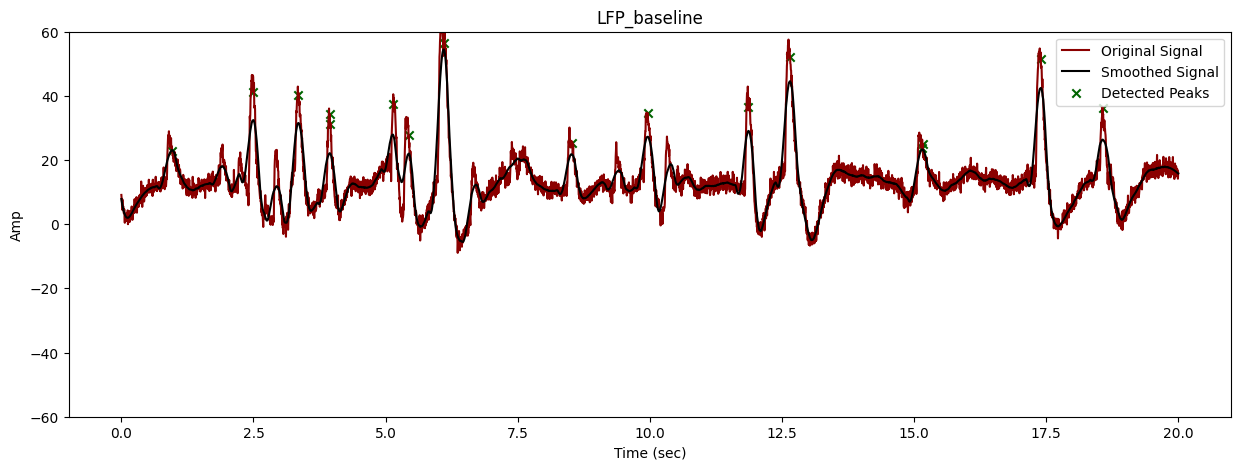

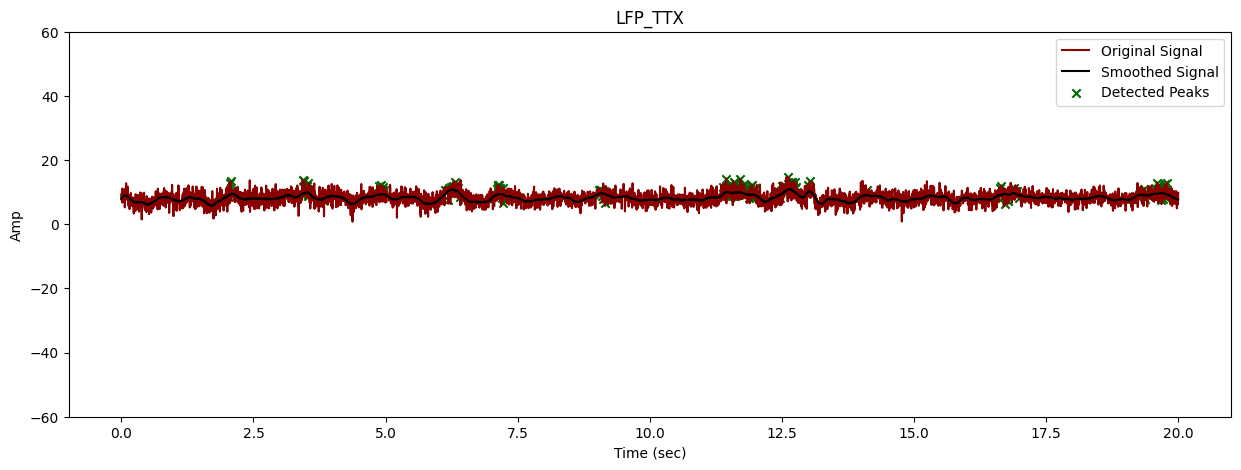

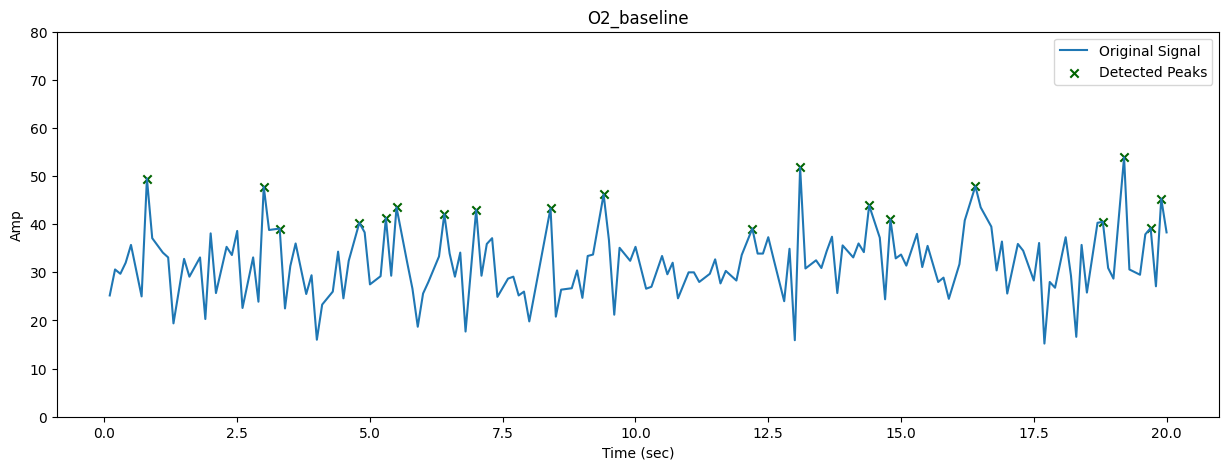

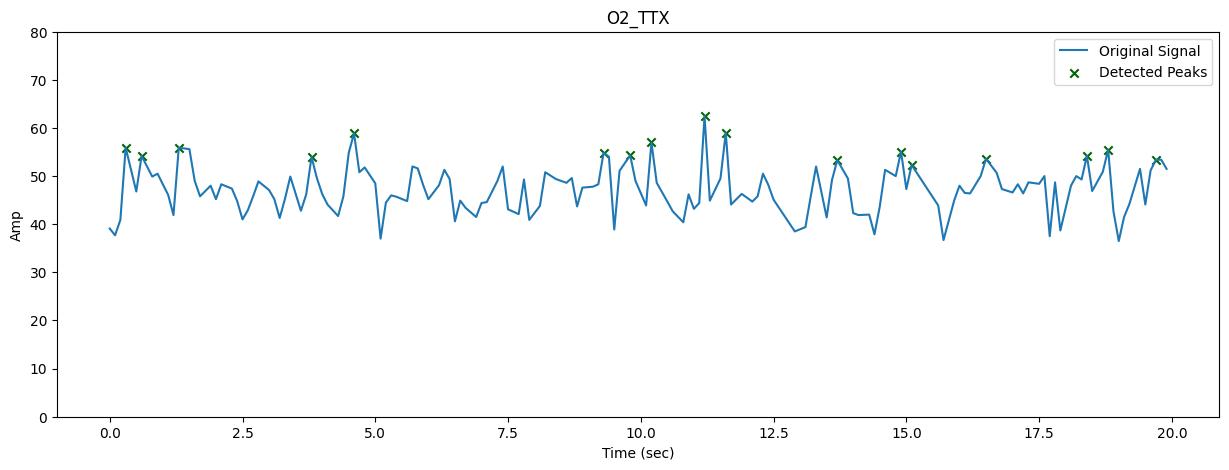

In [20]:
for exp_name, params in exp_dict.items():
    if 'LFP' in exp_name:
        peaks = process_and_plot_signal(params['data_df'], exp_name, 'lfp', threshold_factor=1)
        exp_dict[exp_name]['peaks_df'] = peaks
    elif 'O2' in exp_name:
        peaks = process_and_plot_signal(params['data_df'], exp_name, 'o2', threshold_factor=1)
        exp_dict[exp_name]['peaks_df'] = peaks

In [ ]:
sns.swarmplot(x='Counter', y='Peak Height', hue='Condition', data=all_data,
                          # palette=['#517e95', '#52cbde'], size=6, dodge=True)
                          palette=['royalblue', 'violet'], size=dot_size, dodge=True)

In [31]:
def normalize_peaks(baseline_peaks, ttx_peaks):
    """
    Normalize baseline and TTX peak amplitudes using a common min–max scaling.
    Both conditions share the same min and max values.
    """

    # Convert to numpy arrays
    baseline_peaks = np.array(baseline_peaks)
    ttx_peaks = np.array(ttx_peaks)

    # Combine both conditions for common normalization
    combined = np.concatenate([baseline_peaks, ttx_peaks])

    # Compute min and max
    min_val = np.min(combined)
    max_val = np.max(combined)

    # Handle flat case (max == min)
    if max_val - min_val == 0:
        norm_baseline = np.zeros_like(baseline_peaks)
        norm_ttx = np.zeros_like(ttx_peaks)
    else:
        norm_baseline = (baseline_peaks - min_val) / (max_val - min_val)
        norm_ttx = (ttx_peaks - min_val) / (max_val - min_val)

    return norm_baseline, norm_ttx


In [35]:
exp_dict['LFP_baseline']['peaks_df']['Peak Height']

0     22.800300
1     41.138900
2     44.257976
3     38.167549
4     35.040993
5     41.406302
6     31.592805
7     61.592412
8     34.096668
9     43.549265
10    45.310758
11    61.149234
12    32.780223
13    33.991951
14    60.550850
15    45.179861
Name: Peak Height, dtype: float64

In [39]:
# create 1 dataframe for all peaks data
peaks_lfp = pd.DataFrame()
peaks_o2 = pd.DataFrame()

norm_baseline_lfp, norm_ttx_lfp = normalize_peaks(exp_dict['LFP_baseline']['peaks_df']['Peak Height'], exp_dict['LFP_TTX']['peaks_df']['Peak Height'])
norm_baseline_o2, norm_ttx_o2 = normalize_peaks(exp_dict['O2_baseline']['peaks_df']['Peak Height'], exp_dict['O2_TTX']['peaks_df']['Peak Height'])
# conmbine normalized data into peaks_lfp and peaks_o2 dataframes
peaks_lfp = pd.DataFrame({
    'Peak Height': np.concatenate([norm_baseline_lfp, norm_ttx_lfp]),
    'Condition': ['Baseline'] * len(norm_baseline_lfp) + ['TTX'] * len(norm_ttx_lfp),
    'Counter': [1] * len(norm_baseline_lfp) + [2] * len(norm_ttx_lfp)
})
peaks_o2 = pd.DataFrame({
    'Peak Height': np.concatenate([norm_baseline_o2, norm_ttx_o2]),
    'Condition': ['Baseline'] * len(norm_baseline_o2) + ['TTX'] * len(norm_ttx_o2),
    'Counter': [1] * len(norm_baseline_o2) + [2] * len(norm_ttx_o2)
})

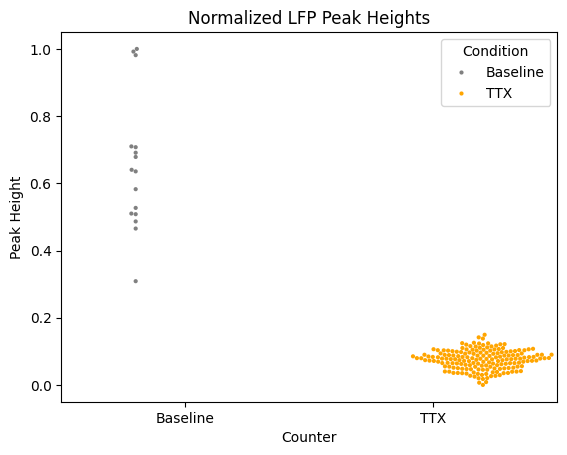

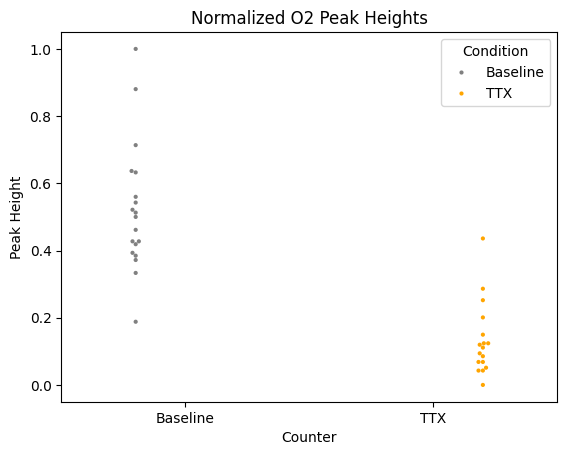

In [44]:
sns.swarmplot(x='Counter', y='Peak Height', hue='Condition', data=peaks_lfp,
                          # palette=['#517e95', '#52cbde'], size=6, dodge=True)
                          palette=['gray', 'orange'], size=3, dodge=True)
plt.title('Normalized LFP Peak Heights')
plt.xticks([0,1], ['Baseline', 'TTX'])

plt.show()

sns.swarmplot(x='Counter', y='Peak Height', hue='Condition', data=peaks_o2,
                          # palette=['#517e95', '#52cbde'], size=6, dodge=True)
                          palette=['gray', 'orange'], size=3, dodge=True)
plt.title('Normalized O2 Peak Heights')
plt.xticks([0,1], ['Baseline', 'TTX'])

plt.show()